In [1]:
import pandas as pd
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('pengunjung.csv')
df.head()

,umur,pekerjaan,status_pernikahan,kredit,saldo,cicilan,pinjaman,membership
0,58,management,married,no,2143,yes,no,no
1,44,technician,single,no,29,yes,no,no
2,33,entrepreneur,married,no,2,yes,yes,no
3,47,blue-collar,married,no,1506,yes,no,no
4,33,unknown,single,no,1,no,no,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   umur               45211 non-null  int64 
 1   pekerjaan          45211 non-null  object
 2   status_pernikahan  45211 non-null  object
 3   kredit             45211 non-null  object
 4   saldo              45211 non-null  int64 
 5   cicilan            45211 non-null  object
 6   pinjaman           45211 non-null  object
 7   membership         45211 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.8+ MB


Dari hasil di atas, dapat dilihat bahwa dataset pengunjung memiliki 8 kolom dan 4521 entries. Kolom umur dan saldo merupakan integer, dan yang lainnya merupakan objek.

In [4]:
#Cek Missing Value
df.isna().sum()

umur                 0
pekerjaan            0
status_pernikahan    0
kredit               0
saldo                0
cicilan              0
pinjaman             0
membership           0
dtype: int64

Output: Tidak terdapat missing value dari dataset tersebut.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = [LabelEncoder(), LabelEncoder(), LabelEncoder()]


df['kredit'] = le[1].fit_transform(df['kredit'])
df['cicilan'] = le[1].fit_transform(df['cicilan'])
df['pinjaman'] = le[1].fit_transform(df['pinjaman'])
df['membership'] = le[1].fit_transform(df['membership'])

Output: Mengubah kolom kategori menjadi 0 dan 1. 0 untuk 'no', dan 1 untuk 'yes'

In [6]:
df.head()

,umur,pekerjaan,status_pernikahan,kredit,saldo,cicilan,pinjaman,membership
0,58,management,married,0,2143,1,0,0
1,44,technician,single,0,29,1,0,0
2,33,entrepreneur,married,0,2,1,1,0
3,47,blue-collar,married,0,1506,1,0,0
4,33,unknown,single,0,1,0,0,0


# Segmentasi

Menggunakan K-Means. Metode ini membagi data menjadi kelompok-kelompok berdasarkan jarak antara titik data dengan pusat kluster terdekat.

In [7]:
#Definisi variabel x
x = df[['kredit', 'saldo', 'cicilan', 'pinjaman']]

**Mencari outliner**

Text(0.5, 0, 'Attributes')

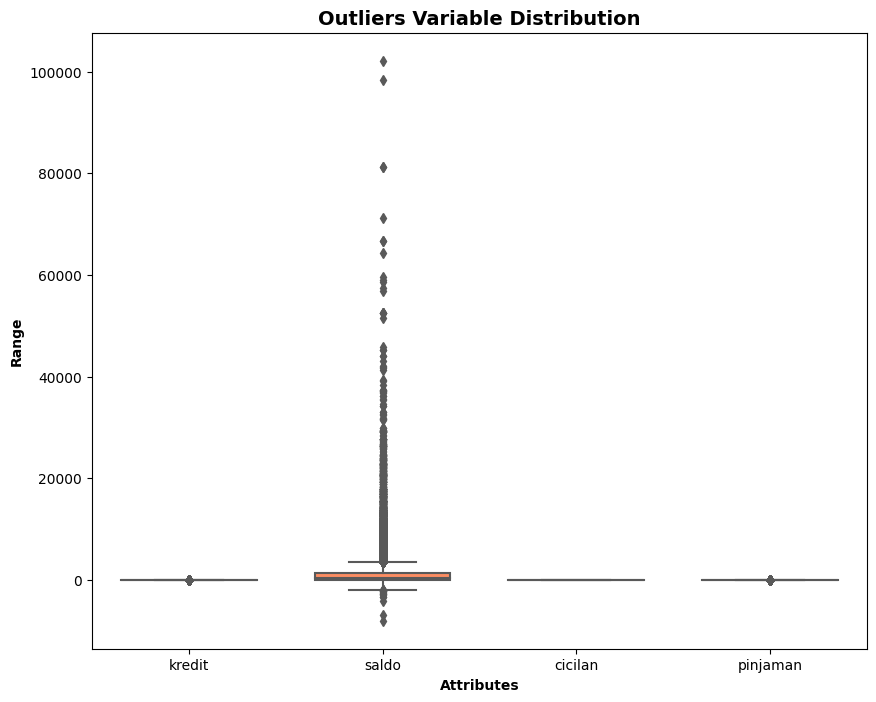

In [8]:
from matplotlib.projections.polar import PolarTransform
attributes = ['kredit', 'saldo', 'cicilan', 'pinjaman']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data = x[attributes], orient = 'v', palette = 'Set2', whis = 1.5, saturation = 1, width = 0.7)
plt.title('Outliers Variable Distribution', fontsize = 14, fontweight = 'bold')
plt.ylabel('Range', fontweight = 'bold')
plt.xlabel('Attributes', fontweight = 'bold')


In [9]:
# Removing (statistical) outliers for Monetary
Q1 = x.saldo.quantile(0.05)
Q3 = x.saldo.quantile(0.95)
IQR = Q3 - Q1
rfm = x[(x.saldo >= Q1 - 1.5*IQR) & (x.saldo <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Recency
Q1 = x.kredit.quantile(0.05)
Q3 = x.kredit.quantile(0.95)
IQR = Q3 - Q1
rfm = x[(x.kredit >= Q1 - 1.5*IQR) & (x.kredit <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = x.cicilan.quantile(0.05)
Q3 = x.cicilan.quantile(0.95)
IQR = Q3 - Q1
rfm = x[(x.cicilan >= Q1 - 1.5*IQR) & (x.cicilan <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = x.pinjaman.quantile(0.05)
Q3 = x.pinjaman.quantile(0.95)
IQR = Q3 - Q1
rfm = x[(x.pinjaman >= Q1 - 1.5*IQR) & (x.pinjaman <= Q3 + 1.5*IQR)]

Pada kode di atas, dilakukan perhitungan Q1 dan Q3 pada setiap kolom dengan menggunakan aturan outlier IQR*1.5 dalam menentukan batas atas dan batas bawah data yang tidak dianggap outlier.

In [10]:
from sklearn.preprocessing import StandardScaler
#Rescaling atribut
rfm_df = rfm[['kredit', 'saldo', 'cicilan', 'pinjaman']]

#instantiate
scaler = StandardScaler()

#fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(45211, 4)

Dengan menggunakan StandardScaler, atribut dalam rfm_df akan memiliki skala yang sama dan distribusi yang standar. Hal ini berguna ketika menggunakan algoritma yang membutuhkan data dengan skala yang serupa, seperti K-means atau SVM.

Menggunakan rescaling atau standardisasi atribut dapat membantu menghindari bias pada atribut dengan rentang nilai yang lebih besar, dan memastikan bahwa setiap atribut memberikan kontribusi yang setara dalam proses analisis dan pemodelan.

In [11]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'kredit', 'cicilan', 'pinjaman']
rfm_df_scaled.head()

,Amount,kredit,cicilan,pinjaman
0,-0.13549,0.256419,0.893915,-0.436803
1,-0.13549,-0.437895,0.893915,-0.436803
2,-0.13549,-0.446762,0.893915,2.289359
3,-0.13549,0.047205,0.893915,-0.436803
4,-0.13549,-0.447091,-1.118674,-0.436803


Langkah dilakukan untuk menghasilkan dataframe baru yang dapat digunakan sebagai analisis dan pemodelan lanjut dengan asumis atribut memiliki skala yang seruba dan distribusi yang standar.

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [13]:
kmeans.labels_

array([0, 0, 2, ..., 1, 1, 1], dtype=int32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

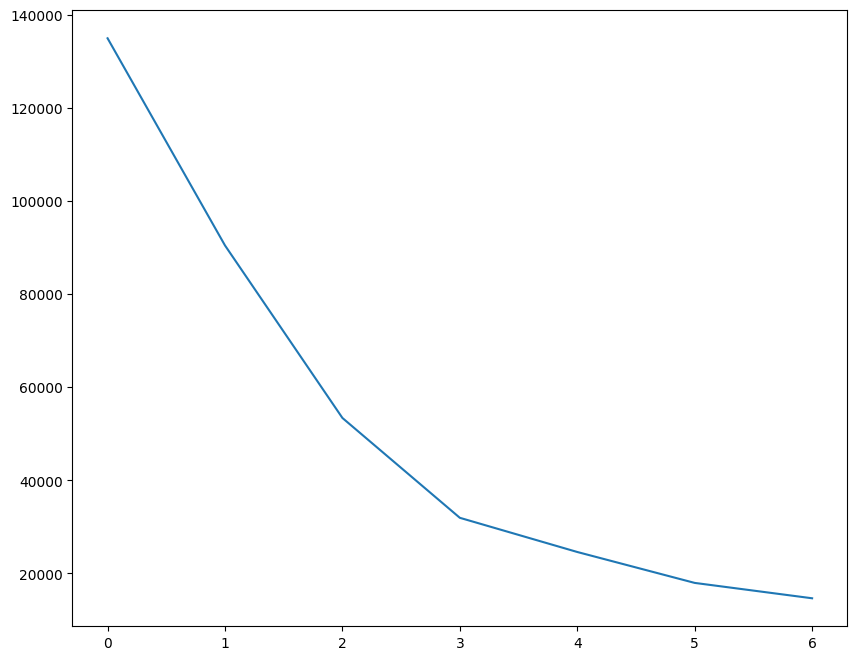

In [14]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

Dapat dilihat pada grafik di atas, dapat mencari "siku" (elbow) di grafik yang menunjukkan penurunan SSD yang signifikan. Elbow tersebut merupakan indikasi jumlah kluster yang optimal untuk dataset yang digunakan. Jumlah kluster yang optimal adalah jumlah kluster di sekitar "siku" tersebut.

In [15]:
from sklearn.metrics import silhouette_score
# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:

    # Initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_

    # Silhouette Score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5380378721960117


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5452213142787756


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.6946446353796644


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.7333330330759824


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.7456075950625635


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.7838784014244496


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.7832095702300188


In [16]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=2)

In [17]:
# Assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,kredit,saldo,cicilan,pinjaman,Cluster_Id
0,0,2143,1,0,0
1,0,29,1,0,0
2,0,2,1,1,1
3,0,1506,1,0,0
4,0,1,0,0,0


<Axes: xlabel='Cluster_Id', ylabel='saldo'>

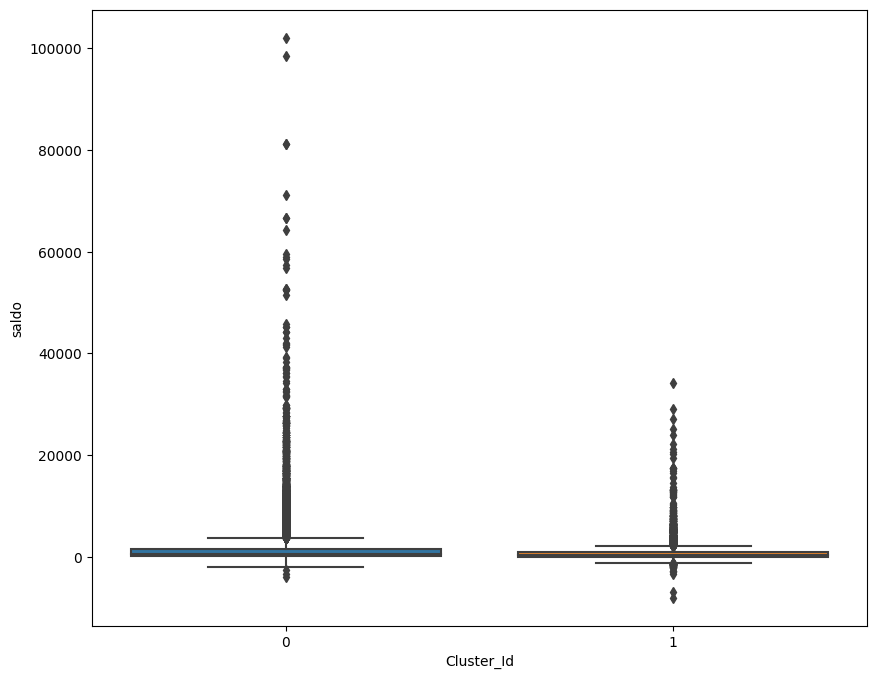

In [18]:
# Boxplot untuk memvisualisasikan Cluster Id dan Monetary
sns.boxplot(x='Cluster_Id', y='saldo', data=rfm)

# SVM

In [19]:
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

In [20]:
df.head()

,umur,pekerjaan,status_pernikahan,kredit,saldo,cicilan,pinjaman,membership
0,58,management,married,0,2143,1,0,0
1,44,technician,single,0,29,1,0,0
2,33,entrepreneur,married,0,2,1,1,0
3,47,blue-collar,married,0,1506,1,0,0
4,33,unknown,single,0,1,0,0,0


In [21]:
# Persiapkan dataset dengan atribut-atribut yang relevan dan target
X = df[['kredit', 'saldo', 'cicilan', 'pinjaman']]
y = df['membership']

In [22]:
# Bagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definisikan parameter yang akan dievaluasi
parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10]}

# Inisialisasi model SVM
svm = SVC()

# Cari parameter terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=parameters, cv=3)
grid_search.fit(X_train, y_train)

In [ ]:
# Mendapatkan parameter terbaik
best_params = grid_search.best_params_
print("Parameter terbaik:", best_params)

# Membuat model SVM dengan parameter terbaik
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Evaluasi model pada data uji
y_pred = best_svm.predict(X_test)
report = classification_report(y_test, y_pred)
print("Laporan Klasifikasi:\n", report)